<a href="https://colab.research.google.com/github/tomohiko-urai/minnano_ai/blob/master/09_Diff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 画像の差分をもとめる

## サンプル１
<img src="https://storage.googleapis.com/iotcolab2023/020144095.jpg" width="30%"> a1.jpg
<img src="https://storage.googleapis.com/iotcolab2023/020155653.jpg" width="30%"> b1.jpg


## サンプル２

<img src="https://storage.googleapis.com/iotcolab2023/circle_rectangle1.png" width="30%"> a2.png
<img src="https://storage.googleapis.com/iotcolab2023/circle_rectangle2.png" width="30%"> b2.png

In [ ]:
!wget https://storage.googleapis.com/iotcolab2023/020144095.jpg -O a1.jpg
!wget https://storage.googleapis.com/iotcolab2023/020155653.jpg -O b1.jpg
!wget https://storage.googleapis.com/iotcolab2023/circle_rectangle1.png -O a2.png
!wget https://storage.googleapis.com/iotcolab2023/circle_rectangle2.png -O b2.png

--2023-02-11 02:06:38--  https://storage.googleapis.com/iotcolab2023/020144095.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.203.128, 172.253.123.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 508210 (496K) [image/jpeg]
Saving to: ‘a1.jpg’

a1.jpg              100%[===================>] 496.30K  --.-KB/s    in 0.006s  

2023-02-11 02:06:39 (84.4 MB/s) - ‘a1.jpg’ saved [508210/508210]

--2023-02-11 02:06:39--  https://storage.googleapis.com/iotcolab2023/020155653.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.203.128, 172.253.123.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 545417 (533K) [image/jpeg]
Saving to: ‘b1.jpg’

b1.jpg              100%[===================>] 532.63K 

In [ ]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os

from google.colab.patches import cv2_imshow

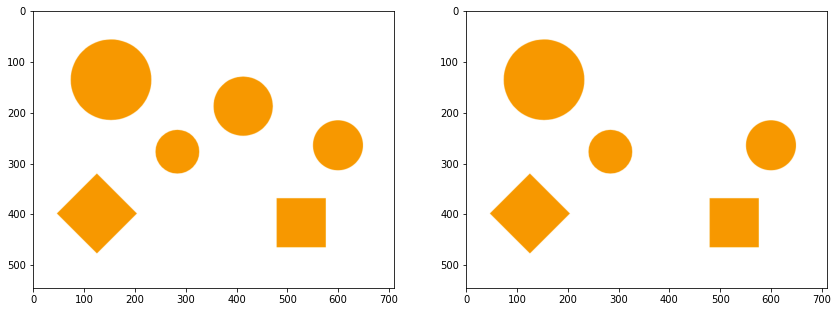

In [ ]:
fileNo = '2' #@param ["1", "2"]

if fileNo == '1':
  filename = ['a1.jpg', 'b1.jpg']
else:  
  filename = ['a2.png', 'b2.png']

imgA = cv2.imread(filename[0])
imgB = cv2.imread(filename[1])

# OpenCVはBRGフォーマットなので、RGBへ変換する
imgA_rgb = cv2.cvtColor(imgA, cv2.COLOR_BGR2RGB)
imgB_rgb = cv2.cvtColor(imgB, cv2.COLOR_BGR2RGB)

# 画像サイズを取得
hA, wA, cA = imgA.shape[:3]
hB, wB, cA = imgB.shape [:3]

px = 1/plt.rcParams['figure.dpi']
fig, axs = plt.subplots(1, 2, figsize=(1024*px, 384*px))
axs[0].imshow(imgA_rgb)
axs[1].imshow(imgB_rgb)

In [ ]:
# 特徴量検出器を作成
akaze = cv2.AKAZE_create()

# 二つの画像の特徴点を抽出
kpA, desA = akaze.detectAndCompute(imgA, None)
kpB, desB = akaze.detectAndCompute(imgB, None)

In [ ]:
# BFMatcher型のオブジェクトを作成する
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# 記述子を一致させる
matches = bf.match(desA, desB)

# 距離の順に並べ替える
matches = sorted(matches, key = lambda x:x.distance)

# 先頭から上位約15%を取り出す
good = matches[:int(len(matches) * 0.15)]

# 特徴点の座標を取り出す
src_pts = np.float32([kpA[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
dst_pts = np.float32([kpB[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

# ホモグラフィ変換行列をもとめる
## ホモグラフィとは、平面を射影変換を用いて別の平面に射影すること
H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

# imgRightを射影変換。
imgB_transform = cv2.warpPerspective(imgB, H, (wA, hA))

In [ ]:
# imgAとdst_imgの差分を求めてresultとする。グレースケールに変換。
result = cv2.absdiff(imgA, imgB_transform)
# result = cv2.absdiff(imgA, imgB)
result_gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
# 二値化
_, result_bin = cv2.threshold(result_gray, 50, 255, cv2.THRESH_BINARY) # 閾値は50

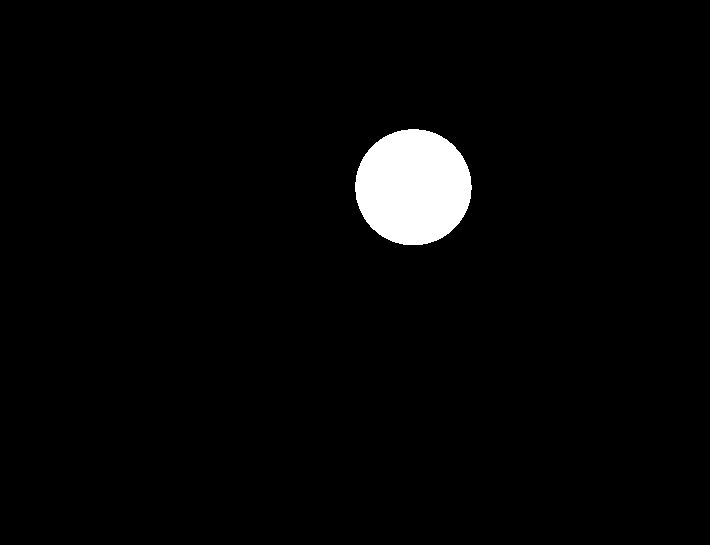

In [ ]:
cv2_imshow(result_bin)

In [ ]:
# 二値画像をRGB形式に変換し、2枚の画像を重ねる。
result_bin_rgb = cv2.cvtColor(result_bin, cv2.COLOR_GRAY2RGB)
result_add = cv2.addWeighted(imgA, 0.3, result_bin_rgb, 0.7, 2.2) # ２.２はガンマ値。大きくすると白っぽくなる

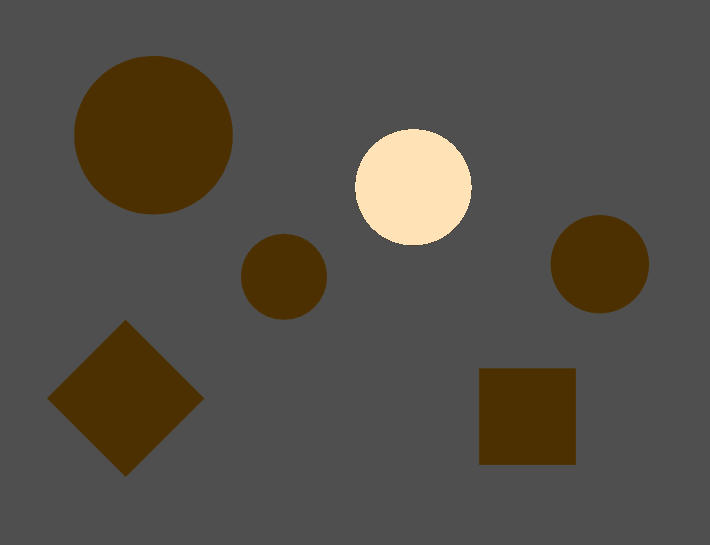

In [ ]:
cv2_imshow(result_add)